# Manifold Datasets

---
author: "Hamidreza Kamkari"
code-tools: true
code-fold: true
jupyter: python3
---

This notebook contains an overview of the different types of manifold datasets and distributions that are available for benchmarking different methods. All of these datasets have a corresponding torch distribution where you can define and sample from.


In [3]:
#| output: false
#| warning: false

from notebook_setup import device

import torch

device = torch.device("cpu")
import matplotlib.pyplot as plt

%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Lollipop

This is a dataset that contains three submanifolds: (1) a candy which is a 2D circle, (2) a stick which is a 1D line, and (3) an isolated point. You can tune the center of the candy and the length of the stick if you want. 

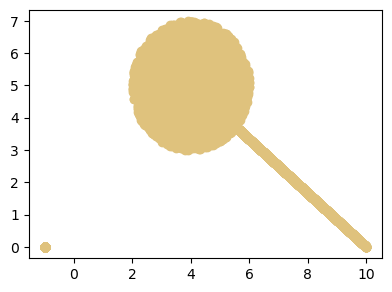

In [20]:
%autoreload 2

from data.distributions import Lollipop
from visualization.pretty import ColorTheme

lollipop_distribution = Lollipop(
    center_loc=(4, 5),
    radius= 2.0,
    stick_end_loc=(10, 0),
    dot_loc = (-1.0, 0.0),
    candy_ratio=1,
    stick_ratio=1,
    dot_ratio=1,
)
fig, ax = plt.subplots(1, 1, figsize=(4, 3))

x = lollipop_distribution.sample(10000)
ax.scatter(x[:, 0], x[:, 1], color=ColorTheme.GOLD.value)
plt.tight_layout(pad=1.0)
plt.show()

## Swiss Roll

This is a tasty 2D swiss roll embedded in 3D space!

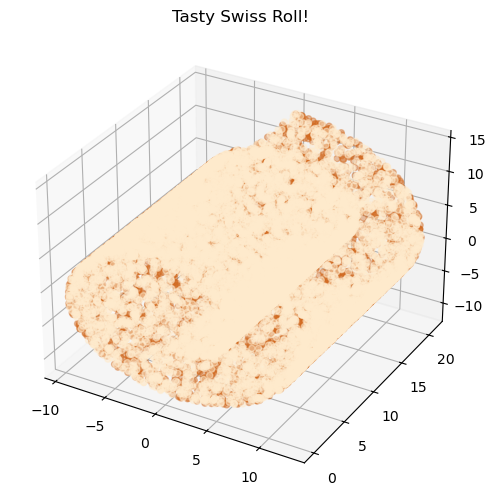

In [22]:
%autoreload 2
from data.distributions import SwissRoll
from visualization.pretty import ColorTheme
distribution = SwissRoll()

cream = distribution.sample(10000) # sample the cream!
chocolate = distribution.sample(10000) # sample the chocolate!
plt.figure(figsize=(8, 6))
ax = plt.axes(projection='3d')

# plot them using a map c which is set to colors
ax.scatter(cream[:, 0], cream[:, 1], cream[:, 2], color=ColorTheme.CREAM.value , alpha=0.5)
ax.scatter(chocolate[:, 0], chocolate[:, 1], chocolate[:, 2], color=ColorTheme.CHOCOLATE.value, alpha=0.4)
plt.title("Tasty Swiss Roll!")
plt.show()
    

## Affine Manifolds

You can also instantiate a distribution which is a mixture of different dimensional affine manifolds. For example, the following code instantiates a distribution with 3 affine manifolds: a 3D cube, a 1D line, and an isolated point.

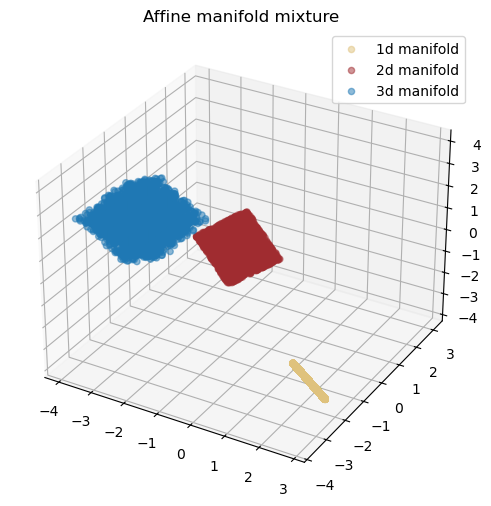

In [23]:
%autoreload 2
from data.distributions import AffineManifoldMixture
from visualization.pretty import ColorTheme

distribution = AffineManifoldMixture(
    manifold_dims=[1, 2, 3],
    ambient_dim=3,
    affine_projection_type="random-rotation",
    mixture_probs=[0.5, 0.25, 0.25], # if you don't set it it will assign equal probabilities to each component
    seed=111,
    distance_between_modes=7,
)

ret = distribution.sample(10000, return_dict=True)
data = ret["samples"]
idx = ret["idx"]

plt.figure(figsize=(8, 6))
ax = plt.axes(projection='3d')

ax.scatter(data[idx==0, 0], data[idx==0, 1], data[idx==0, 2], color=ColorTheme.GOLD.value, alpha=0.5, label="1d manifold")
ax.scatter(data[idx==1, 0], data[idx==1, 1], data[idx==1, 2], color=ColorTheme.RED_FIRST.value, alpha=0.5, label="2d manifold")
ax.scatter(data[idx==2, 0], data[idx==2, 1], data[idx==2, 2], color=ColorTheme.BLUE_FIRST.value, alpha=0.5, label="3d manifold")
plt.title("Affine manifold mixture")
plt.legend()
plt.show()
    

The way this distribution works is that for each manifold of intrinsic dimensionality 'd', the distribution samples a point from a d-dimensional standard normal/uniform/laplace distribution and then applies an affine transformation to it to embedd it in a higher dimensional space. There are four different types of projections:

1. **Orthogonal**: The affine transformation is a random orthogonal matrix.
2. **Random**: The affine transformation is a random matrix.
3. **Repeat**: Repeat the elements until the desired dimensionality is reached. For example, to embed `[1, 2, 3]` in a 5D space, the result would be `[1, 2, 3, 1, 2]`.
4. **Zero-pad**: The affine transformation pads the vector with zeros until the desired dimensionality is reached.

It isn't recommended to use the random projection because a random linear transform might squeeze or stretch the data in a way that might impact the empirical LID of the manifold. In other words, if the manifold is squeezed dramatically in one direction, the LID might become lower.

## Unlocking generic manifolds using diffeomorphic transformations

Although affine manifolds are good, they are not flexible and cannot represent the distribution of complex dataset such as images. To create a harder manifold benchmark, pass each affine manifold through a diffeomorphism to obtain a more complex manifold with the same intrinsic dimensionality. The class `ManifoldMixtures` allows you to define a distribution with a mixture of different manifolds by first performing an affine projection and then applying an arbitrary diffeomorphism on each of the mixture components.

These diffeomporphisms can be obtained from a normalizing flow, allowing full flexibility defining the distribution. As an example, run the following code which instantiates a mixture of 4 manifolds: two 1D and two 2D manifolds where one of each is also passed through a neural spline flow to become non-linear:

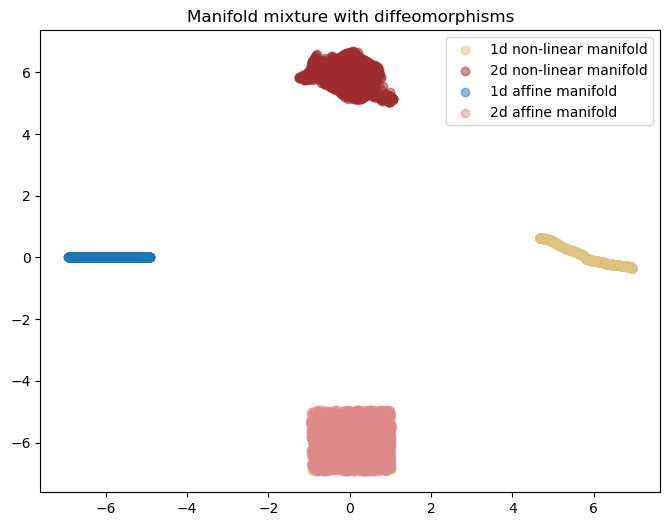

In [24]:
%autoreload 2
from data.distributions import ManifoldMixture
from models.flows.diffeomorphisms import RQNSF
import functools
from visualization.pretty import ColorTheme
        
rq_nsf_diffeo = functools.partial(
    RQNSF, 
    n_transforms=32, 
    n_hidden=32, 
    n_blocks=3, 
)


distribution = ManifoldMixture(
    manifold_dims=[1, 2, 1, 2],
    ambient_dim=2,
    diffeomorphism_instantiator=[rq_nsf_diffeo, rq_nsf_diffeo, None, None], # the first two are passed through diffeomorphisms
    affine_projection_type="zero-pad",
    distance_between_modes=6,
    sample_distr="uniform",
    seed=666,
)


ret = distribution.sample((10000, ), chunk_size=128, return_dict=True)
data = ret["samples"]
lid = ret["lid"]
idx = ret["idx"]

plt.figure(figsize=(8, 6))
plt.scatter(data[idx == 0, 0], data[idx==0, 1], color=ColorTheme.GOLD.value, alpha=0.5, label="1d non-linear manifold")
plt.scatter(data[idx == 1, 0], data[idx==1, 1], color=ColorTheme.RED_FIRST.value, alpha=0.5, label="2d non-linear manifold")
plt.scatter(data[idx == 2, 0], data[idx==2, 1], color=ColorTheme.BLUE_FIRST.value, alpha=0.5, label="1d affine manifold")
plt.scatter(data[idx == 3, 0], data[idx==3, 1], color=ColorTheme.RED_SECOND.value, alpha=0.5, label="2d affine manifold")
plt.legend()
plt.title("Manifold mixture with diffeomorphisms")
plt.show()

Generally, increasing the number of transforms in the RQ-NSF would increase the complexity. 

**NOTE**: Beware that while using complex diffeomorphisms does not change the intrinsic dimensionality of the manifold in theory, in practice, it might squeeze or stretch the manifold such that the empirical dimensionality does not match the true dimensionality. In this scenario, the distribution can be unfair! Thus, we recommend not going above a number of transforms that is not necessary for the task at hand.

### Additive and Affine flows

You can also use additive or affine flows which are less expressive and can make the benchmark relatively easier. Run the following two blocks to visualize:

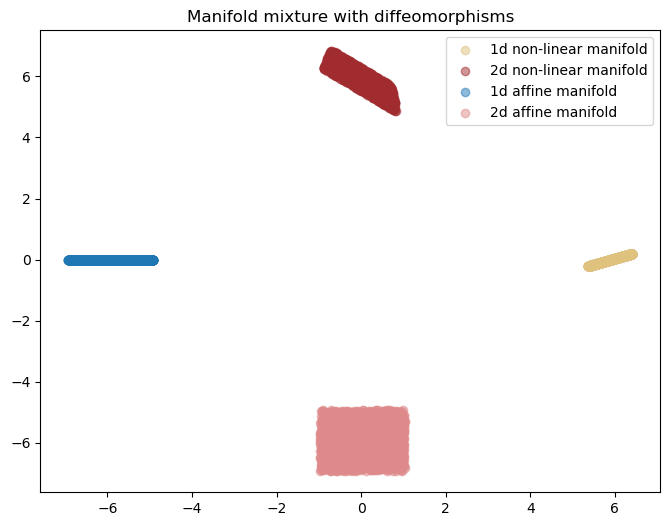

In [25]:
from models.flows.diffeomorphisms import AffineFlow

affine_diffeo = functools.partial(
    AffineFlow,
    n_transforms=10,
    n_hidden=32,
    n_blocks=3,
)


distribution = ManifoldMixture(
    manifold_dims=[1, 2, 1, 2],
    ambient_dim=2,
    diffeomorphism_instantiator=[
        affine_diffeo,
        affine_diffeo,
        None,
        None,
    ],  # the first two are passed through diffeomorphisms
    affine_projection_type="zero-pad",
    distance_between_modes=6,
    sample_distr="uniform",
    seed=666,
)


ret = distribution.sample((10000,), chunk_size=128, return_dict=True)
data = ret["samples"]
lid = ret["lid"]
idx = ret["idx"]
plt.figure(figsize=(8, 6))

plt.scatter(
    data[idx == 0, 0],
    data[idx == 0, 1],
    color=ColorTheme.GOLD.value,
    alpha=0.5,
    label="1d non-linear manifold",
)
plt.scatter(
    data[idx == 1, 0],
    data[idx == 1, 1],
    color=ColorTheme.RED_FIRST.value,
    alpha=0.5,
    label="2d non-linear manifold",
)
plt.scatter(
    data[idx == 2, 0],
    data[idx == 2, 1],
    color=ColorTheme.BLUE_FIRST.value,
    alpha=0.5,
    label="1d affine manifold",
)
plt.scatter(
    data[idx == 3, 0],
    data[idx == 3, 1],
    color=ColorTheme.RED_SECOND.value,
    alpha=0.5,
    label="2d affine manifold",
)
plt.legend()
plt.title("Manifold mixture with diffeomorphisms")
plt.show()

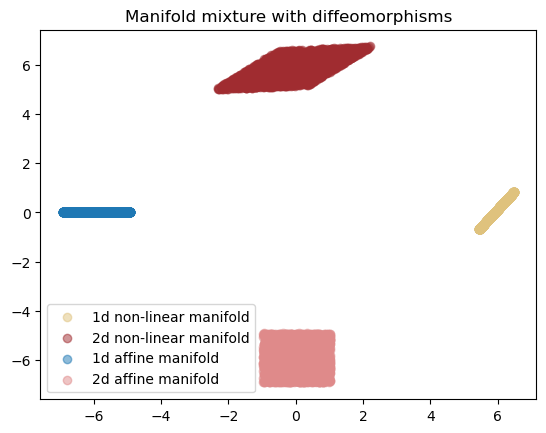

In [12]:
from models.flows.diffeomorphisms import AdditiveFlow

affine_diffeo = functools.partial(
    AdditiveFlow,
    n_transforms=32,
    n_hidden=32,
    n_blocks=3,
)


distribution = ManifoldMixture(
    manifold_dims=[1, 2, 1, 2],
    ambient_dim=2,
    diffeomorphism_instantiator=[
        affine_diffeo,
        affine_diffeo,
        None,
        None,
    ],  # the first two are passed through diffeomorphisms
    affine_projection_type="zero-pad",
    distance_between_modes=6,
    sample_distr="uniform",
    seed=666,
)


ret = distribution.sample((10000,), chunk_size=128, return_dict=True)
data = ret["samples"]
lid = ret["lid"]
idx = ret["idx"]

plt.scatter(
    data[idx == 0, 0],
    data[idx == 0, 1],
    color=ColorTheme.GOLD.value,
    alpha=0.5,
    label="1d non-linear manifold",
)
plt.scatter(
    data[idx == 1, 0],
    data[idx == 1, 1],
    color=ColorTheme.RED_FIRST.value,
    alpha=0.5,
    label="2d non-linear manifold",
)
plt.scatter(
    data[idx == 2, 0],
    data[idx == 2, 1],
    color=ColorTheme.BLUE_FIRST.value,
    alpha=0.5,
    label="1d affine manifold",
)
plt.scatter(
    data[idx == 3, 0],
    data[idx == 3, 1],
    color=ColorTheme.RED_SECOND.value,
    alpha=0.5,
    label="2d affine manifold",
)
plt.legend()
plt.title("Manifold mixture with diffeomorphisms")
plt.show()

### Controlled manifolds using prespecified diffeomorphisms

Here we use controlled diffeomorphisms to rotate the data with a specific degree that we want:

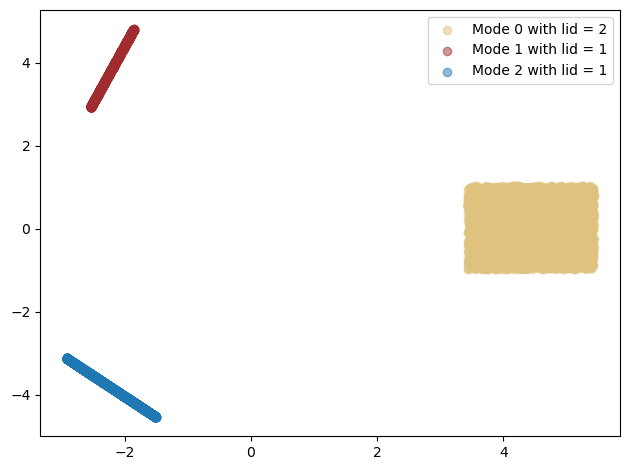

In [26]:
%autoreload 2
from data.distributions import ManifoldMixture
from models.flows.diffeomorphisms import Rotation
import functools
import math

rot110 = functools.partial(Rotation, angles=[110. / 180. * math.pi])
rot45 = functools.partial(Rotation, angles=[45. / 180. * math.pi])

distribution = ManifoldMixture(
    manifold_dims=[2, 1, 1],
    ambient_dim=2,
    diffeomorphism_instantiator=[None, rot110, rot45],
    affine_projection_type="zero-pad",
    distance_between_modes=5,
    sample_distr="uniform",
    seed=53,
)


ret = distribution.sample((10000, 2), return_dict=True)
data = ret["samples"]
lid = ret["lid"]
idx = ret["idx"]
colors = [ColorTheme.GOLD.value, ColorTheme.RED_FIRST.value, ColorTheme.BLUE_FIRST.value]
for i in range(3):
    plt.scatter(data[idx == i, 0], data[idx == i, 1], color=colors[i], label=f"Mode {i} with lid = {lid[idx==i][0]}", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


## Squiggly Manifolds

Squiggly manifolds are a class of good high dimensional benchmarks because they are
1. Highly non-linear
2. Have good condition numbers by design
3. We can control how much non-linear they are using a frequency hyperparameter.

The idea starts off by obvserving that the "squiggly" function $f(x) = x + (1 - \epsilon) \frac{sin(\omega x)}{\omega}$ does not perturb that much as we perturb $x$, thus it has a bounded condition number. Moreover, we can obtain a complex diffeomorphism by chaining elementwise $f(x)$ functions and random rotations. Chaining them would still ensure that the condition numbers are well-behaved but makes them increasingly more non-linear. 

This would give us a good baseline to compare LID estimators with. We know that ESS estmators fail when we increase the frequency term $\omega$.

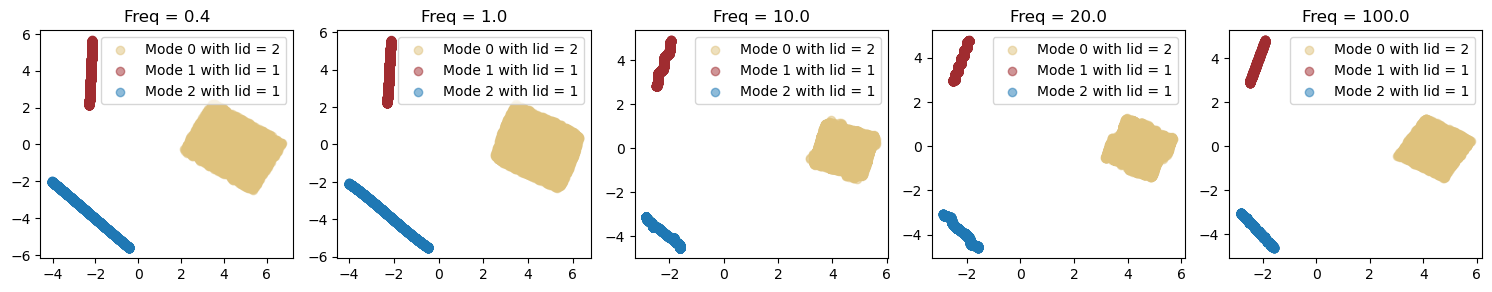

In [37]:
%autoreload 2
from data.distributions import SquigglyManifoldMixture
import functools
from visualization.pretty import ColorTheme

fig, axs = plt.subplots(1, 5, figsize=(15, 3))

for ii, control in enumerate([0.4, 1., 10., 20., 100.]):
    distribution = SquigglyManifoldMixture(
        manifold_dims=[2, 1, 1],
        ambient_dim=2,
        distance_between_modes=5,
        sample_distr="uniform",
        device=device,
        seed=53,
        frequency=control,
    )


    ret = distribution.sample((10000, 2), chunk_size=10000, return_dict=True)
    data = ret["samples"]
    lid = ret["lid"]
    idx = ret["idx"]
    colors = [ColorTheme.GOLD.value, ColorTheme.RED_FIRST.value, ColorTheme.BLUE_FIRST.value]
    for i in range(3):
        axs[ii].scatter(data[idx == i, 0], data[idx == i, 1], color=colors[i], label=f"Mode {i} with lid = {lid[idx==i][0]}", alpha=0.5)
    axs[ii].legend()
    axs[ii].set_title(f"Freq = {control}")
plt.tight_layout(pad=1.0)
plt.show()



Note that at frequency of 100, the frequency is so high that is not visible anymore when we plot the manifold.

## High dimensional Gaussian soap bubbles

The following is an example of a mixture of Gaussians with dimensions 1, 10, 200, and 400 all embedded in an 800 dimensional space. The following visualizes a UMAP representation of it. 

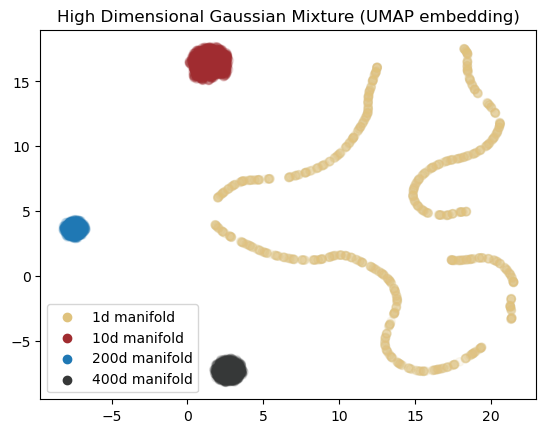

In [10]:
from data.distributions import ManifoldMixture
from visualization.pretty import ColorTheme
from visualization import visualize_umap_clusters

manifold_dims = [1, 10, 200, 400]
distribution = ManifoldMixture(
    manifold_dims=manifold_dims,
    ambient_dim=800,
    distance_between_modes=50,
    sample_distr="normal",
    seed=666,
)

samples_dict = distribution.sample(5000, return_dict=True)
data = samples_dict["samples"]
lid = samples_dict["lid"]
idx = samples_dict["idx"]

clusters = [
    data[idx == 0],
    data[idx == 1],
    data[idx == 2],
    data[idx == 3],
]
colors = [
    ColorTheme.GOLD.value,
    ColorTheme.RED_FIRST.value,
    ColorTheme.BLUE_FIRST.value,
    ColorTheme.PIRATE_BLACK.value,
]

labels = [f"{i}d manifold" for i in manifold_dims]

visualize_umap_clusters(
    data=clusters,
    labels=labels,
    colors=colors,
    title="High Dimensional Gaussian Mixture (UMAP embedding)",
    return_img=False,
)

**NOTE**: For some reason I can't see the soap bubble on the UMAP embedding here!

The following plot shows the norm of the values that are sampled divided by 800. As you can see, for higher dimensional manifolds this norm is more concentrated around `28` which is the radius of the soap-bubble.

[]

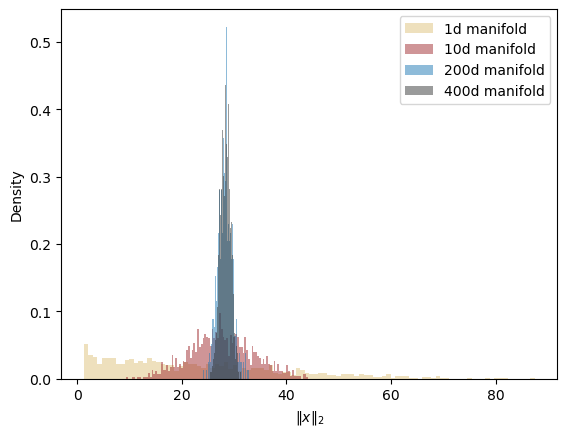

In [14]:
import numpy as np

for i, data in enumerate(clusters):
    standardized = (data - data.mean(0)) / data.std(0)
    norms = np.linalg.norm(standardized, axis=1)
    # plot a histogram of norms
    plt.hist(norms, bins=100, alpha=0.5, color=colors[i], label=labels[i], density=True)
plt.legend()
plt.xlabel("$\\Vert x \\Vert_2$")
plt.ylabel("Density")
plt.plot()